In [1]:
#!nvidia-smi

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchsummary import summary

from DatasetLogReturn import StockDatasetLogReturn
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

import math
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt

In [8]:
configs = {
    "batch_size" : 32,
    "max_file_count" : 2179,
    "train_file" : 7,
    "validation_file" : 3,
    "test_file" : 3,
    "input_size" : 8,
    "output_size" : 1,
    "init_learning_rate" : 1e-4,
    "scheduler_factor": 0.5,
    "scheduler_patience": 2,
    "scheduler_min_lr": 3e-6,
    "epoch" : 10,
    "model_name" : "LSTM7",
}

configs["file_count"] = configs["train_file"] + configs["validation_file"] + configs["test_file"]
configs["model_folder"] = f"./models/{configs["model_name"]}/"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tickers = list(map(str.strip,open("tickers_sp500.txt","r").readlines()))
filenames = ["./data/" + x + ".csv" for x in tickers]
rd.shuffle(filenames)
filenames = filenames[:configs["file_count"]]

train_files, test_files = train_test_split(filenames,test_size=configs["test_file"]/configs["file_count"])
train_files, val_files = train_test_split(train_files,test_size=configs["validation_file"]/(configs["train_file"] + configs["validation_file"]))

train_dataset = StockDatasetLogReturn(train_files, configs["input_size"], configs["output_size"])
train_dataset.Preprocess()
train_loader = DataLoader(train_dataset,batch_size=configs["batch_size"],shuffle=True)

val_dataset = StockDatasetLogReturn(val_files,configs["input_size"],configs["output_size"])
val_dataset.Preprocess()
val_loader = DataLoader(val_dataset,batch_size=configs["batch_size"],shuffle=True)

test_dataset = StockDatasetLogReturn(test_files,configs["input_size"],configs["output_size"])
test_dataset.Preprocess()
test_loader = DataLoader(test_dataset,batch_size=configs["batch_size"],shuffle=True)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/60233 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/29845 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25702 [00:00<?, ?it/s]

In [31]:
torch.set_default_dtype(torch.float32)

class LSTMBlock(nn.Module) :
    def __init__(self, input_size, output_size) :
        super().__init__()
        self.LSTM = nn.LSTM(input_size,output_size,2,batch_first=True,bias=False)
        self.Dropout = nn.Dropout(p=0.2)
        self.LayerNorm = nn.LayerNorm(output_size)
    
    def forward(self, input) :
        h1,_ = self.LSTM(input)
        h2 = self.Dropout(h1)
        output = self.LayerNorm(h2)
        return output

class StockLSTM(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.hidden_size = 512
        self.batch_size = configs["batch_size"]
        self.layer1 = LSTMBlock(4,self.hidden_size)
        self.layer2 = nn.Linear(self.hidden_size,1,bias=False)

    def forward(self, input) :
        input = torch.multiply(input,25)
        h1 = self.layer1(input)
        output = self.layer2(h1[:,-1,:])
        output = torch.multiply(output,0.04)
        return output


In [51]:
model = StockLSTM()
model = model.to(device)

summary(model,input_size=(configs["batch_size"],configs["input_size"],4))

Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTMBlock: 1-1                         --
|    └─LSTM: 2-1                         3,153,920
|    └─Dropout: 2-2                      --
|    └─LayerNorm: 2-3                    1,024
├─Linear: 1-2                            512
Total params: 3,155,456
Trainable params: 3,155,456
Non-trainable params: 0

In [52]:
try_input = torch.zeros(configs["batch_size"],configs["input_size"],4)
try_input = try_input.to(device=device)

dataset = model(try_input)

In [53]:
loss_fn = torch.nn.L1Loss()

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr = configs["init_learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=configs['scheduler_factor'],
    patience=configs['scheduler_patience'],
    min_lr=configs['scheduler_min_lr']
)


In [55]:
train_losses = []
val_losses = []
avarage_train_losses = []
avarage_val_losses = []
learning_rates = []

model_folder = configs["model_folder"]
best_loss = 1000000

for epoch in tqdm(range(configs["epoch"])) :

    model.train()

    learning_rates.append(optimizer.param_groups[0]['lr'])

    cur_train_loss = []
    for input,target in tqdm(train_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        optimizer.zero_grad()

        output = model(close_price_input)

        loss = loss_fn(output,close_price_target)

        loss.backward()

        optimizer.step()

        train_losses.append(loss.to(torch.device("cpu")).item())
        cur_train_loss.append(loss.to(torch.device("cpu")).item())

    avarage_train_loss = np.mean(np.array(cur_train_loss))
    avarage_train_losses.append(avarage_train_loss)

    model.eval()

    with torch.no_grad() :
        cur_val_loss = []
        for input,target in tqdm(val_loader) :

            close_price_input = torch.transpose(input[:,1:5,:],1,2)
            close_price_target = target[:,4,:]
            close_price_input = close_price_input.to(device)
            close_price_target = close_price_target.to(device)

            if(close_price_input.shape[0] != configs["batch_size"]) :
                continue

            output = model(close_price_input)

            loss = loss_fn(output,close_price_target)

            val_losses.append(loss.to(torch.device("cpu")).item())
            cur_val_loss.append(loss.to(torch.device("cpu")).item())

        avarage_val_loss = np.mean(np.array(cur_val_loss))
        avarage_val_losses.append(avarage_val_loss)

        scheduler.step(avarage_val_loss)
        
        if(best_loss > avarage_val_loss) :

            state = {
                'epoch': epoch,
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avarage_train_loss,
                'val_loss': avarage_val_loss,
                'best_val_loss': best_loss,
            }

            best_loss = avarage_val_loss

            torch.save(state, model_folder + "LSTM.pth.tar")

    print("train loss : ",avarage_train_loss)
    print("val loss : ",avarage_val_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.016382911699298498
val loss :  0.016690633889255735


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.016042187972752402
val loss :  0.016563106786915353


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015952830419130426
val loss :  0.01655894151165314


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01589254005124256
val loss :  0.01651701067530354


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01584852538066624
val loss :  0.016513753457538496


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01582683306449666
val loss :  0.016540901043927976


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015807645868482295
val loss :  0.016529238785820907


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01580004548672765
val loss :  0.0164996881123888


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.0157963420723651
val loss :  0.01650580322537811


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015797370167866778
val loss :  0.016495338782004595


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01579689350588827
val loss :  0.016495011919757645


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.0157947572082772
val loss :  0.0165045087649427


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015796174123530907
val loss :  0.01648891806130821


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015795898174928397
val loss :  0.01649621565818243


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015792218685460917
val loss :  0.016491051883208905


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01579133643646003
val loss :  0.016511423326429187


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015783135621342315
val loss :  0.01648599125021197


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015782423074209743
val loss :  0.01650480947721062


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015781863310001195
val loss :  0.01649544023920666


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01578239896448525
val loss :  0.016488868637258274


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01577607972456358
val loss :  0.016483521079464693


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01577261741684827
val loss :  0.016485333600573145


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01576484453703072
val loss :  0.016485427153524603


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01577088774471889
val loss :  0.01648202461546263


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01576264988181679
val loss :  0.016487698550356047


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01576427017649345
val loss :  0.01649093856363529


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.015759519466637426
val loss :  0.01649784106789197


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01575852468348525
val loss :  0.016481724201477744


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01575539253432379
val loss :  0.016488553960148103


  0%|          | 0/1883 [00:00<?, ?it/s]

  0%|          | 0/933 [00:00<?, ?it/s]

train loss :  0.01575465408954512
val loss :  0.016494383002219667


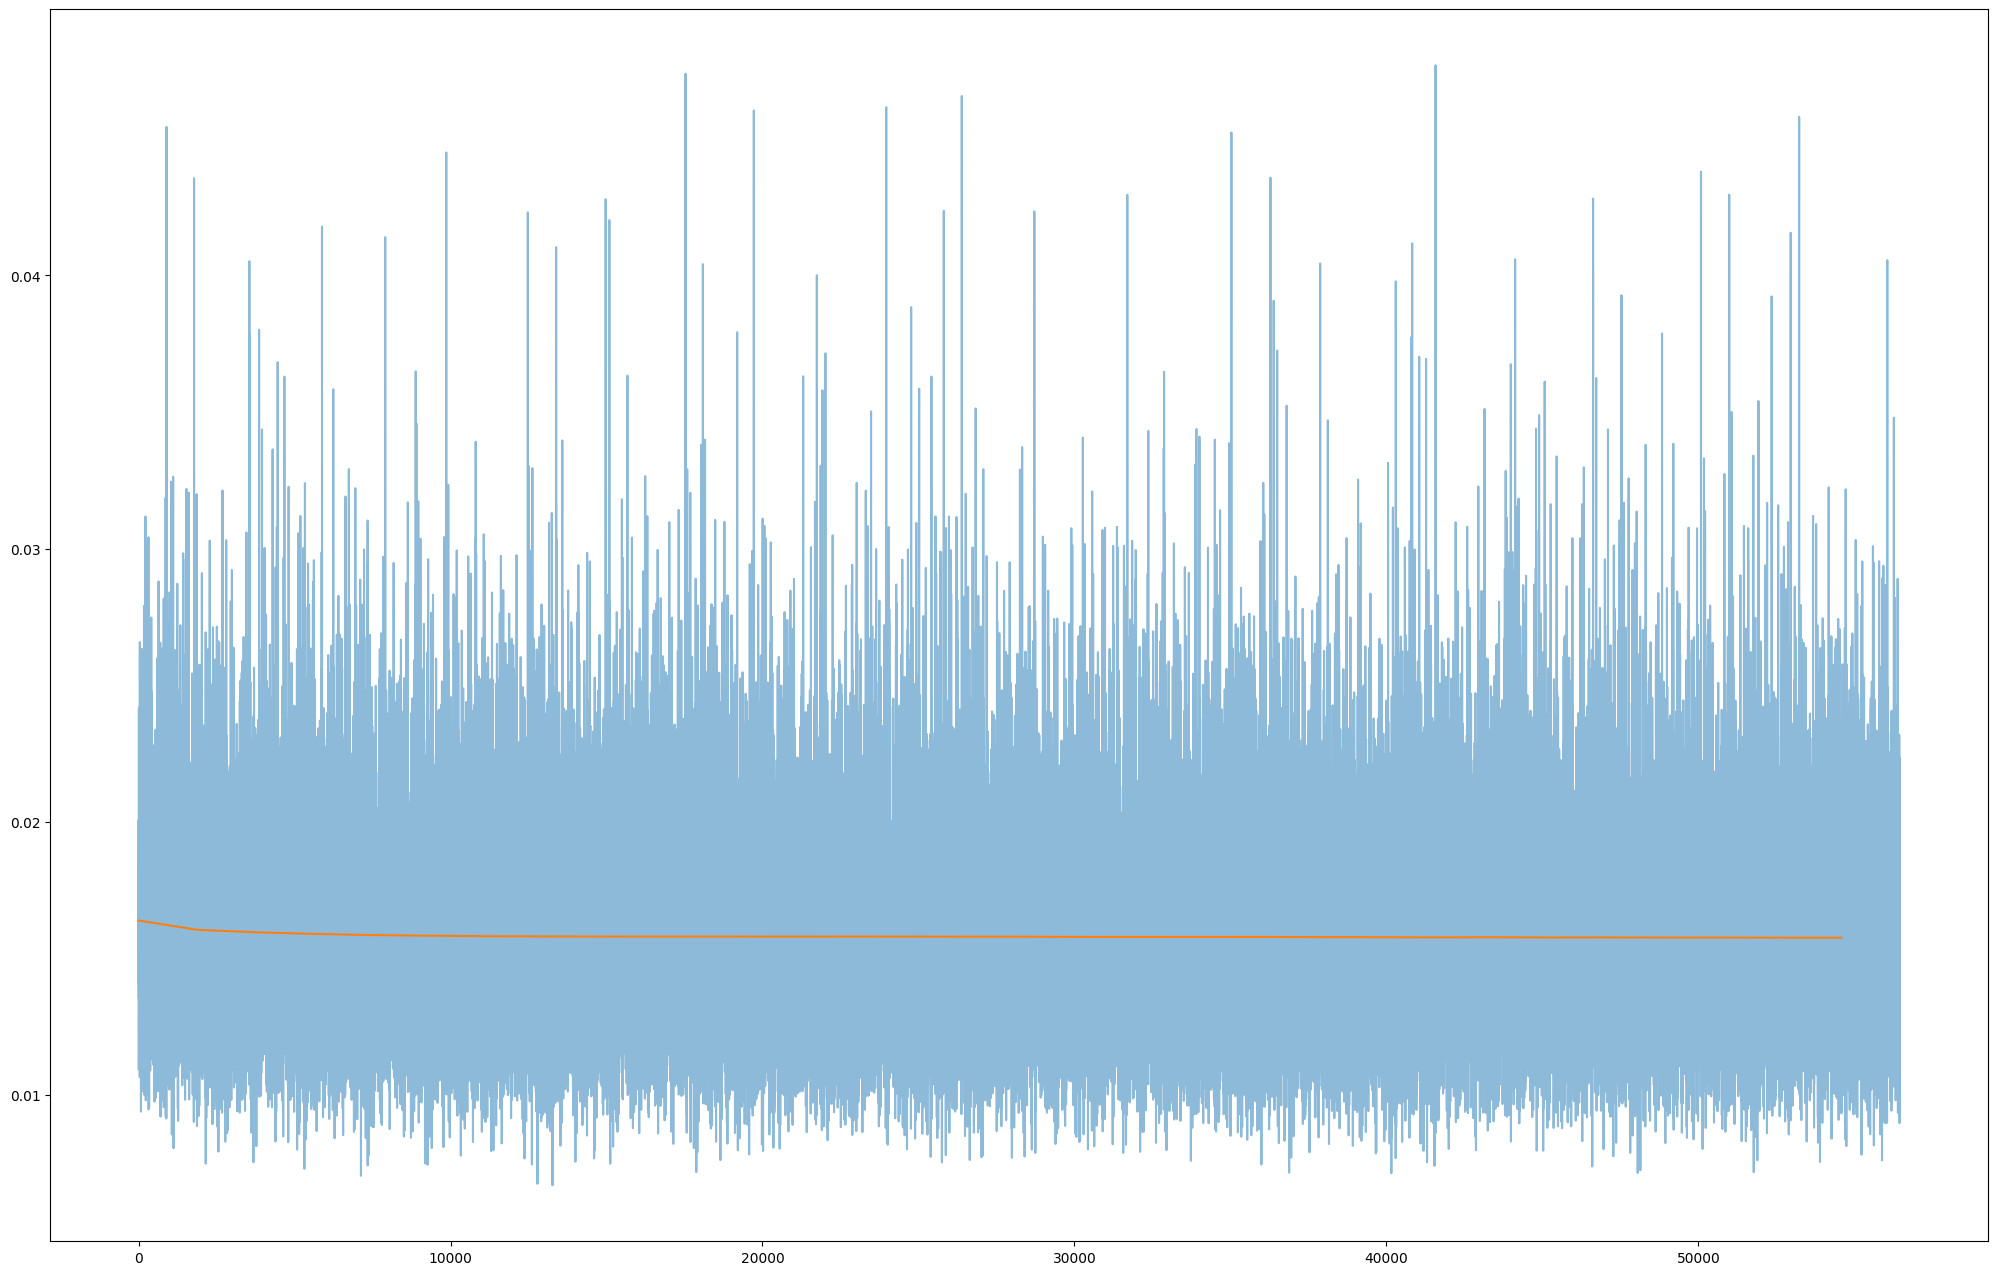

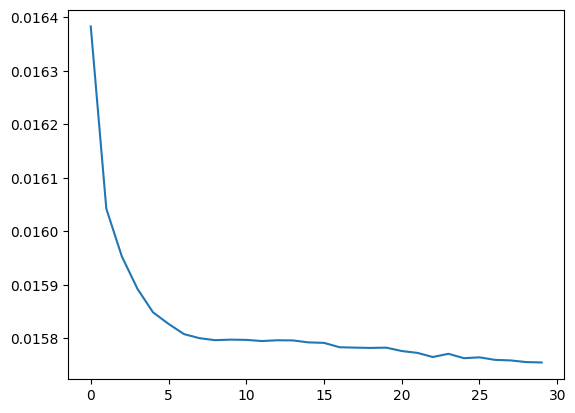

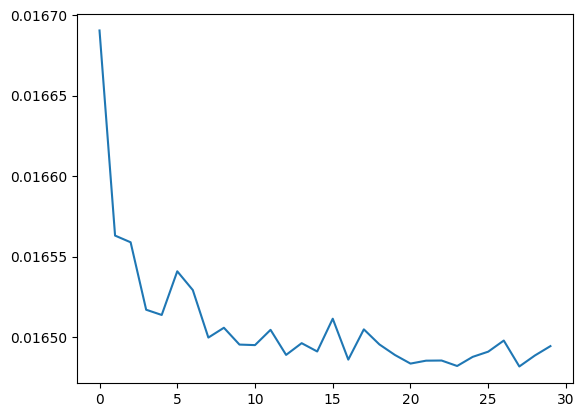

In [56]:
plt.figure(figsize=(25, 16))
plt.plot(train_losses,alpha=0.5)
plt.plot(list(range(0,len(train_losses),int(len(train_losses) / len(avarage_train_losses)))),avarage_train_losses)
plt.show()
plt.plot(avarage_train_losses)
plt.show()
plt.plot(avarage_val_losses)
plt.show()

In [57]:
train_losses_file = open(configs["model_folder"] + "train_losses.txt",'w')
val_losses_file = open(configs["model_folder"] + "val_losses.txt","w")

for value in train_losses :
    train_losses_file.write(f"{value}\n")

for value in val_losses :
    val_losses_file.write(f"{value}\n")

train_losses_file.close()
val_losses_file.close()

In [58]:
best_model = StockLSTM()
# best_model.load_state_dict(torch.load(configs["model_folder"] + "LSTM.pth.tar")['model'])

best_model.to(device)
best_model.eval()

StockLSTM(
  (layer1): LSTMBlock(
    (LSTM): LSTM(4, 512, num_layers=2, bias=False, batch_first=True)
    (Dropout): Dropout(p=0.2, inplace=False)
    (LayerNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (layer2): Linear(in_features=512, out_features=1, bias=False)
)

In [59]:
with torch.no_grad() :
    cur_test_loss = []
    for input,target in tqdm(test_loader) :

        close_price_input = torch.transpose(input[:,1:5,:],1,2)
        close_price_target = target[:,4,:]
        close_price_input = close_price_input.to(device)
        close_price_target = close_price_target.to(device)

        if(close_price_input.shape[0] != configs["batch_size"]) :
            continue

        output = best_model(close_price_input)

        loss = loss_fn(output,close_price_target)

        cur_test_loss.append(loss.to(torch.device("cpu")).item())

    avarage_test_loss = np.mean(np.array(cur_test_loss))

print(avarage_test_loss)

  0%|          | 0/804 [00:00<?, ?it/s]

0.011984121879611447


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/192 [00:00<?, ?it/s]

0.027280904 -> 0.0028553854 
0.00846264 -> 0.007860428 
0.027702712 -> 0.008060572 
-0.010989148 -> 0.0071573462 **
-0.0013822329 -> 0.004644756 **
0.01373648 -> 0.0017919303 
-0.02346552 -> 0.00056202454 **
0.016620858 -> -0.0002096495 **
-0.056512143 -> 0.00070866675 **
-0.030998778 -> -0.0027204873 
0.12525128 -> -0.010946671 **
-0.028170828 -> -0.00075074134 
0.020202698 -> 0.008035698 
-0.0053476966 -> 0.007027041 **
0.01990779 -> 0.0044443617 
0.044965845 -> 0.00426459 
0.059737533 -> 0.007573893 
0.15228924 -> 0.009844784 
0.15762901 -> 0.010655722 
0.09594127 -> 0.01026571 
-0.02475179 -> 0.009392904 **
-0.071189456 -> 0.009289571 **
-0.07946418 -> 0.008570125 **
-0.06403746 -> -0.00693119 
-0.038820002 -> -0.01296998 
0.080042735 -> -0.013813282 **
0.058813017 -> -0.010879219 **
-0.013692594 -> 0.0033687644 **
-0.020427812 -> 0.007623018 **
0.014897877 -> 0.0041367197 
0.011029468 -> 0.0047580167 
0.044690236 -> 0.0012797154 
-0.021202233 -> 0.004933156 **
-0.027151005 -> 0.00

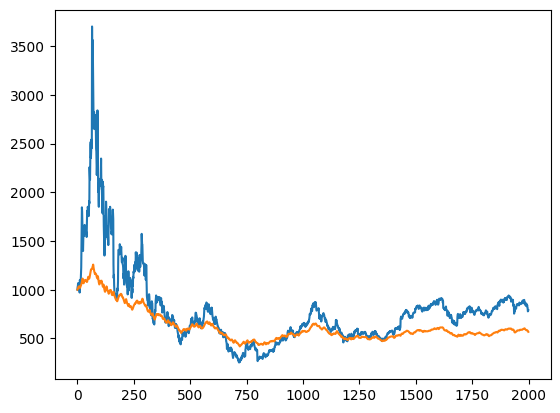

In [64]:
plot_dataset = StockDatasetLogReturn(["./data/A.csv"],configs["input_size"],1)

real = [1000]
predict = [1000]
price = 1000

feed_queue = list(range(plot_dataset.__len__()))
rd.shuffle(feed_queue)
predict_output = []
real_output = []
with torch.no_grad() : 
    for i in tqdm(range(0,plot_dataset.__len__(),configs["batch_size"])) :
        close_price_input = []
        close_price_target = []
        for j in range(configs["batch_size"]) :
            input,target = plot_dataset.__getitem__(i + j)
            close_price_input.append(torch.transpose(input[None,1:5,:],1,2))
            close_price_target.append(target[4].numpy())
        close_price_input = torch.cat(close_price_input).to(device)

        output = best_model(close_price_input)
        output = output.to(torch.device("cpu")).numpy()

        for j in range(configs["batch_size"]) :
            real_output.append(math.exp(close_price_target[j][0]))
            predict_output.append(math.exp(output[j][0]))
            print(close_price_target[j][0],"->",output[j][0],"**" if close_price_target[j][0] * output[j][0] < 0 else "")

for i in range(len(predict_output)) :
    predict.append(predict[-1] * predict_output[i])
    real.append(real[-1] * real_output[i])

plt.plot(real[0:2000])
plt.plot(predict[0:2000])
plt.show()

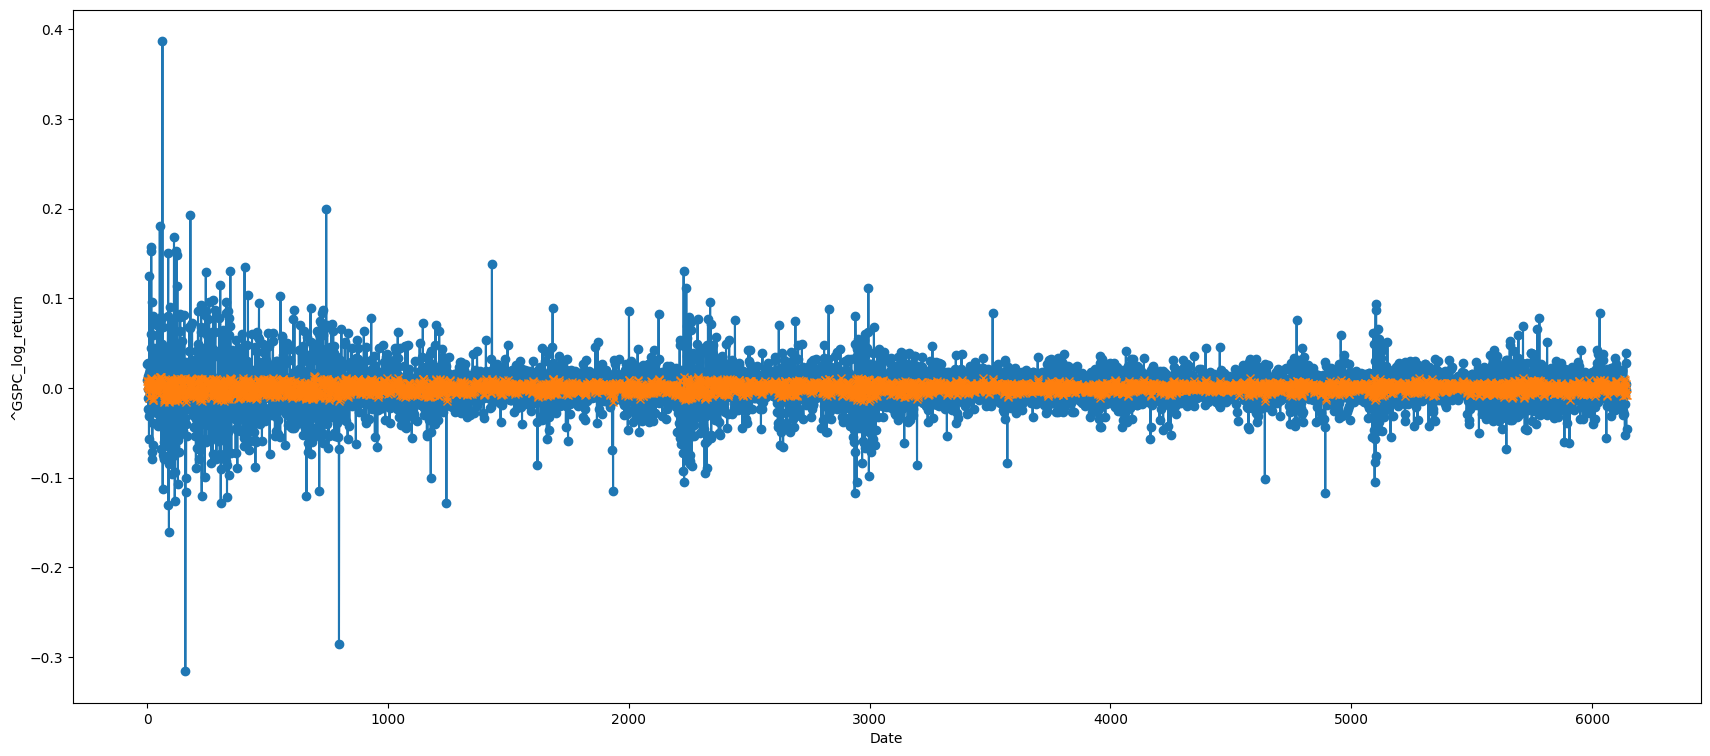

In [65]:
log_real_output = list(map(math.log,real_output))
log_predict_output = list(map(math.log,predict_output))
plt.figure(figsize=(21, 9))
plt.plot(log_real_output, label="Actual", marker='o')
plt.plot(log_predict_output, label= "Predicted",marker='x')
plt.xlabel('Date')
plt.ylabel('^GSPC_log_return')
plt.show()

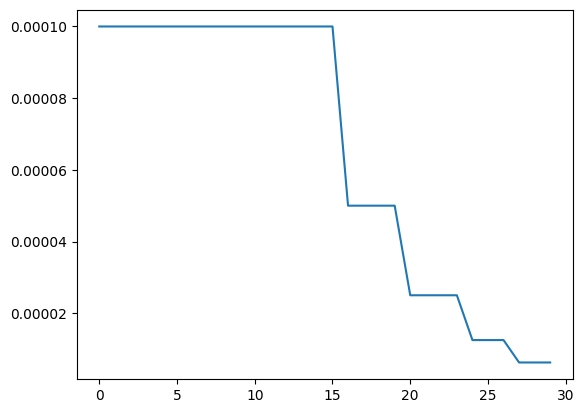

In [66]:
plt.plot(learning_rates)
plt.show()